# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchinfo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive

In [5]:
import polcanet.reports as report
import polcanet.utils as ut
import polcanet.mlutils as mlut
from polcanet import PolcaNet

In [6]:
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
print('CUDA available:', torch.cuda.is_available())
print('cuDNN version:', torch.backends.cudnn.version())
print('cuDNN enabled:', torch.backends.cudnn.enabled)

CUDA available: True
cuDNN version: 90100
cuDNN enabled: True


### Set with or without classification Labels

In [7]:
with_labels = False

In [8]:
if with_labels:
    name = "MNIST_dataset_labels"
else:
    name = "MNIST_dataset"
    
exp = ut.ExperimentInfoHandler(
    name=name,
    description="POLCA-Net on MNIST dataset",
    random_seed=random_seed,
)
ut.set_save_fig(True)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving data: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving data: True, saving in path: /data1/deploy/polcanet/examples/notebooks/output/experiments/MNIST_dataset


### Load dataset

In [9]:
from torchvision.datasets import MNIST
mnist_trainset = MNIST(root="data/MNIST", train=True, download=True, transform=None)
mnist_testset = MNIST(root="data/MNIST", train=False, download=True, transform=None)

In [10]:
train_dataset = mnist_trainset.data.reshape(-1, 28, 28) / 255.0
eval_dataset = mnist_testset.data.reshape(-1, 28, 28) / 255.0
y = mnist_trainset.targets.numpy()
y_test = mnist_testset.targets.numpy()

labels = np.unique(y) if with_labels else None

X = np.array(train_dataset.numpy(), dtype=np.float32)
X = np.squeeze(X)
print(X.min(),X.max())
X_test = np.array(eval_dataset.numpy(), dtype=np.float32)
X_test = np.squeeze(X_test)
train_dataset.shape, eval_dataset.shape, X.shape,X_test.shape, y.shape, y_test.shape, labels

0.0 1.0


(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 (60000, 28, 28),
 (10000, 28, 28),
 (60000,),
 (10000,),
 None)

In [11]:
def random_sample(x,y=None,n=1000):
    indices = np.random.choice(x.shape[0], min(x.shape[0],n), replace=False)
    if y is None:
        return x[indices]
    return x[indices], y[indices]

In [12]:
# X,y = random_sample(X, y ,12000)
# X_test, y_test = random_sample(X_test, y_test ,3000)
# X.shape,X_test.shape, y.shape, y_test.shape

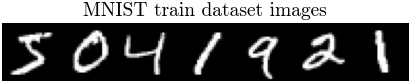

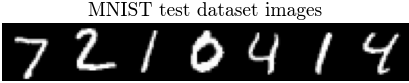

In [13]:
ut.set_fig_prefix("sin_train")
ut.plot_train_images(X, "MNIST train dataset images",cmap="gray", n=7)
ut.set_fig_prefix("sin_test")
ut.plot_train_images(X_test, "MNIST test dataset images",cmap="gray", n=7)

### Fit standard sklearn PCA

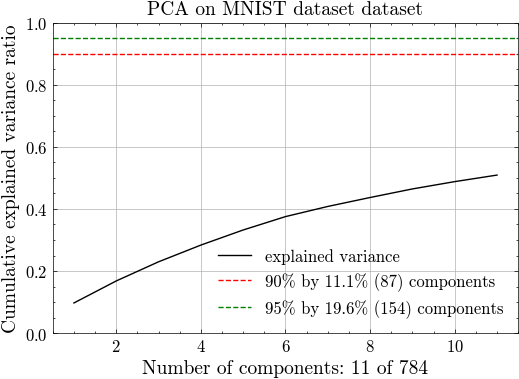

In [14]:
n_components = 11 #  Heuristic sqrt(image size)
pca = ut.perform_pca(X, n_components=n_components, title="PCA on MNIST dataset dataset")
Xpca = pca.transform(np.squeeze(X.reshape(X.shape[0], -1)))
plt.show()

### Fit POLCANet

In [15]:
N = X[0].shape[0]
M = X[0].shape[1]

In [16]:
import polcanet.aencoders as pae

act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder = pae.ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=6,
    act_fn=act_fn,
    size=N,
)

decoder = pae.LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=8 * 256,
    num_layers=3,
    act_fn=nn.GELU,
    bias=False,
)



decoder =  pae.LinearConvDecoder(
    latent_dim=latent_dim,
    hidden_sizes=[64, 128, 256, 256],  
    output_dim=input_dim,   
    act_fn=nn.GELU,
    bias = False,
)

model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    r=1,  # reconstruction loss weight
    c=1e-1 if with_labels else 0,  # classification loss (cross ent) weight
    alpha=1e-1 if with_labels else 1,  # ortgogonality loss
    beta=1e-1 if with_labels else 1,  # variance sorting loss
    gamma=0,  # variance reduction loss
    class_labels=labels,  # class labels for supervised in case labels is not None
    std_noise=0.0,
    blend_prob = 0.5,
)

print(model)
print("X[0:1] shape",torch.as_tensor(X[:1]).shape)
summary = torchinfo.summary(
    model,
    input_data = torch.as_tensor(X[:1]),
    dtypes=[torch.float32],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
    depth=1,
)
ut.save_text(str(model), "model.txt")
ut.save_text(str(summary), "model_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (2): SiLU()
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): SiLU()
        (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): SiLU()
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (8): SiLU()
        (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): SiLU()
        (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (12): SiLU()
        (13): Flatten(start_dim=1, end_dim=-1)
        (14): Linear(in_features=512, out_features=11, bias=True)
        (15): SiLU()
      )
    )
    (polca_bottleneck): Sequential(
      (0): Linear(in_featur

In [17]:
model.to(device)
model.train_model(data=X, val_data=X_test,y=y, val_y=y_test,batch_size=512, num_epochs=50, report_freq=1, lr=1e-3)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Output()


Final Train metrics at epoch: 50
Total Loss: 0.009802
Reconstruction Loss: 0.006247
Orthogonality Loss: 0.002833
Center of Mass Loss: 0.0007215

Final Validation metrics at epoch: 50
Total Loss: 0.009004
Reconstruction Loss: 0.00637
Orthogonality Loss: 0.001882
Center of Mass Loss: 0.0007516


In [18]:
model.train_model(data=X, val_data=X_test,y=y, val_y=y_test,batch_size=512, num_epochs=25, report_freq=1, lr=1e-4)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Output()


Final Train metrics at epoch: 25
Total Loss: 0.007139
Reconstruction Loss: 0.005113
Orthogonality Loss: 0.001698
Center of Mass Loss: 0.0003277

Final Validation metrics at epoch: 25
Total Loss: 0.005893
Reconstruction Loss: 0.005181
Orthogonality Loss: 0.0003844
Center of Mass Loss: 0.000328


In [32]:
model.train_model(data=X, val_data=X_test,y=y, val_y=y_test,batch_size=512, num_epochs=25, report_freq=1, lr=1e-5)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Output()


Final Train metrics at epoch: 25
Total Loss: 0.006712
Reconstruction Loss: 0.004968
Orthogonality Loss: 0.001481
Center of Mass Loss: 0.0002627

Final Validation metrics at epoch: 25
Total Loss: 0.005664
Reconstruction Loss: 0.005071
Orthogonality Loss: 0.0003277
Center of Mass Loss: 0.0002651


## Evaluate results

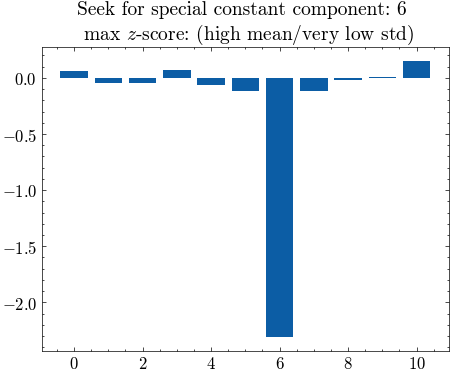

What does this component mean? an intercept? a dataset invariant?


In [20]:
plt.figure()
z_score = model.mu.cpu() / model.std.cpu()
special_constant = np.argmax(z_score.abs())
plt.bar(range(latent_dim), z_score, label="std")
plt.title(f"Seek for special constant component: {special_constant} \n" + " max $z$-score: (high mean/very low std)" )
plt.show()
print("What does this component mean? an intercept? a dataset invariant?")

### Losses Interactions Analysis

In [21]:
ut.set_fig_prefix("train")
report.loss_interaction_analysis(model)

Loss Interaction Analysis Report:
Total interactions: 573
Total conflicts: 212
Overall conflict rate: 0.3700

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,rec,com,573,127,0.2216,-0.0008,Weakly Conflicting
1,ort,com,573,14,0.0244,0.0878,Weakly Cooperative
2,rec,ort,573,71,0.1239,0.2690,Strongly Cooperative


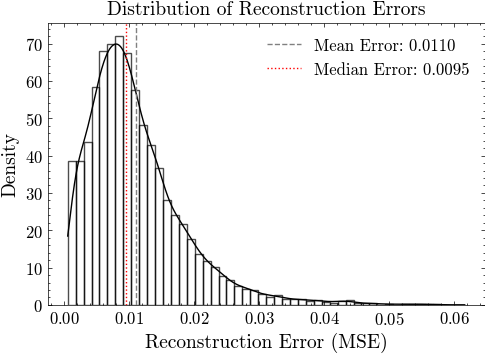

Mean Reconstruction Error: 0.0110
Median Reconstruction Error: 0.0095
Min Reconstruction Error: 0.0005
Max Reconstruction Error: 0.0616


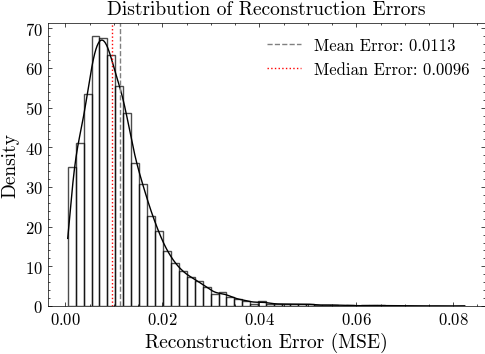

Mean Reconstruction Error: 0.0113
Median Reconstruction Error: 0.0096
Min Reconstruction Error: 0.0005
Max Reconstruction Error: 0.0824


In [22]:
ut.set_fig_prefix("train")
report.analyze_reconstruction_error(model, X)
ut.set_fig_prefix("test")
report.analyze_reconstruction_error(model, X_test)

### Reconstruction Analysis

In [23]:
latents, reconstructed = model.predict(X)

In [24]:
def plot_reconstruction(n_components):
    images = X[0:16]
    ut.plot_reconstruction_comparison(
        model,pca,images,cmap="gray",nrow=4, n_components=n_components)
    images = X_test[0:16]
    ut.plot_reconstruction_comparison(
        model,pca,images,cmap="gray",nrow=4, n_components=n_components)


interact(
    plot_reconstruction,
    n_components=widgets.IntSlider(min=1, max=pca.n_components, step=1, value=pca.n_components),
);

interactive(children=(IntSlider(value=11, description='n_components', max=11, min=1), Output()), _dom_classes=…

### Orthogonality Analysis

In [25]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    print("TRAIN")
    ut.set_fig_prefix("train")
    report.orthogonality_test_analysis(model,pca, X)
with o2:
    print("TEST")
    ut.set_fig_prefix("test")
    report.orthogonality_test_analysis(model,pca, X_test)
    
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

### Variance Analysis

In [26]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    print("TRAIN")
    ut.set_fig_prefix("train")
    report.variance_test_analysis(model, X)
with o2:
    print("TEST")
    ut.set_fig_prefix("test")
    report.variance_test_analysis(model, X_test)
    
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

### Linear properties

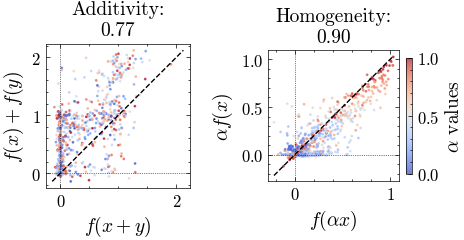

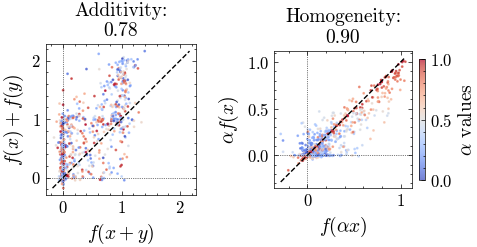

In [27]:
ut.set_fig_prefix("train")
report.linearity_tests_analysis(model, X,alpha_min=0, num_samples=200)
ut.set_fig_prefix("test")
report.linearity_tests_analysis(model, X_test,alpha_min=0, num_samples=200)

### 2D embeddings

In [28]:
def plot_embeddings(c_0=0,c_1=1):
    o1 = widgets.Output()
    o2 = widgets.Output()
    with o1:
        _, _ = ut.plot2d_analysis(Xpca, y, title="PCA transform", legend=True,c0=c_0,c1=c_1)
    with o2:
        _, _ = ut.plot2d_analysis(latents, y, title="POLCA-Net latent",  legend=True,c0=c_0,c1=c_1)
    layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
    accordion = widgets.GridBox(children=[o1, o2], layout=layout)
    display(accordion)
interact(plot_embeddings,c_0=(0,latents.shape[1]-1),c_1=(0,latents.shape[1]-1));

interactive(children=(IntSlider(value=0, description='c_0', max=10), IntSlider(value=1, description='c_1', max…

# Test Classification PCA vs. POLCA Net

In [29]:
def classify(n_components=pca.n_components):
    clear_output(wait=True)
    ut.make_classification_report(model, pca, X, y, X_test, y_test, n_components=n_components)


interact(
    classify,
    n_components=widgets.IntSlider(min=1, max=pca.n_components, step=1, value=pca.n_components),
);

interactive(children=(IntSlider(value=11, description='n_components', max=11, min=1), Output()), _dom_classes=…

In [30]:
experiment_data = {
    "MNIST train": (
        X_test,
        model,
        pca,
    ),
    "MNIST test": (
        X,
        model,
        pca,
    ),
}
df_table = ut.image_metrics_table(experiment_data)

,NMSE,PSNR,SSI
Method,,,
POLCA MNIST train,0.3041,20.5351,0.8635
PCA MNIST train,0.5454,15.1314,0.5013
POLCA MNIST test,0.3038,20.5960,0.8650
PCA MNIST test,0.5531,15.0848,0.4956


In [31]:
df_table.T

Method,POLCA MNIST train,PCA MNIST train,POLCA MNIST test,PCA MNIST test
NMSE,0.3041,0.5454,0.3038,0.5531
PSNR,20.5351,15.1314,20.5960,15.0848
SSI,0.8635,0.5013,0.8650,0.4956
